# load math data to see what ripples do during periods of reversed spectral tilt found in Randazzo and Ezzyat's analysis (2021-11-10)

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1' 'RepFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
subs = ['R1030J','R1035M'] # MFG subs

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
145,NaN,protocols/r1/subjects/R1030J/experiments/FR1/s...,protocols/r1/subjects/R1030J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1030J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1030J/localizations/0/m...,NaN,0,R1030J,R1030J,NaN,protocols/r1/subjects/R1030J/experiments/FR1/s...
190,NaN,protocols/r1/subjects/R1035M/experiments/FR1/s...,protocols/r1/subjects/R1035M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1035M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1035M/localizations/0/m...,NaN,0,R1035M,R1035M,1.0,protocols/r1/subjects/R1035M/experiments/FR1/s...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[4:7]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(565, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2540,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2545,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2549,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


# ClusterLoad

In [52]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'math'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 0
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'nonHPC_MTL' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in exp_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    session_events = session_events[temp_recall_idxs]
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2021-11-10_19-26-59: DF Exception: Sub: R1026D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/MATH/SWR_FR1_R1026D_0_nonHPC_MTL_math_soz_in_hamming.p', file: <ipython-input-52-cd288018309c>, line no: 66
2021-11-10_19-26-59: DF Exception: Sub: R1045E, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/MATH/SWR_FR1_R1045E_0_nonHPC_MTL_math_soz_in_hamming.p', file: <ipython-input-52-cd288018309c>, line no: 66
2021-11-10_19-27-07: DF Exception: Sub: R1108J, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/MATH/SWR_FR1_R1108J_0_nonHPC_MTL_math_soz_in_hamming.p', file: <ipython-input-52-cd288018309c>, line no: 66
2021-11-10_19-27-12: DF Exception: Sub: R1134T, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/MATH/SWR_FR1_R1134T_2_nonHPC_MTL_math_soz_in_hamming.p', file: <ipython-input-52-cd288018309c>, line no: 66
20

107.78443113772455

% of HPC recalls for FR1


214.8815730671831

(129825, 2000)

From 339/538 sessions with >0 nonHPC_MTL electrodes
Total trials: 129825
Unique sessions: 339
...from 180 patients
Number of electrodes: 955
Electrode regions X sessions:
79 for  left amygdala
37 for  left ent entorhinal area
31 for  left phg parahippocampal gyrus
167 for  left tmp temporal pole
62 for  right amygdala
13 for  right ent entorhinal area
38 for  right phg parahippocampal gyrus
34 for  right tmp temporal pole
9 for "ba35"
65 for "ba36"
3 for "erc"
39 for "phc"
13 for ba35
84 for ba36
149 for entorhinal
220 for left amy
86 for left amygdala
30 for left ec
69 for left ent entorhinal area
81 for left mtl wm
54 for left phc
45 for left phg parahippocampal gyrus
135 for left prc
265 for left tmp temporal pole
142 for parahippocampal
128 for phc
167 for right amy
64 for right amygdala
23 for right ec
21 for right ent entorhinal area
53 for right mtl wm
32 for right phc
46 for right phg parahippocampal gyrus
57 for right prc
70 for right tmp temporal pole
122 for temporalpole


## get start array

In [53]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval']:
    list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
    rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
    session_events = session_events[updated_recalls]
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')


Total electrodes loaded: 1742
from 339 sessions from 180 subjects with trial nums:
[ 31.  31.  31.  91.  91.  91.  91.  91.  91. 106. 106. 106. 106. 106.
 106. 106. 125. 154.  78.  78.]
Trial sum = 129825.0
['left prc', 'left prc', 'right ec', 'temporalpole', 'temporalpole', 'parahippocampal', 'temporalpole', 'right amy', 'right amy', 'temporalpole', 'temporalpole', 'parahippocampal', 'parahippocampal', 'temporalpole', 'right amy', 'right amy', 'temporalpole', 'temporalpole', 'parahippocampal', 'right amy']
Number of sub_sess names: 1742
Got start_array with 129825 trials!


## big raster

(129825, 2000)


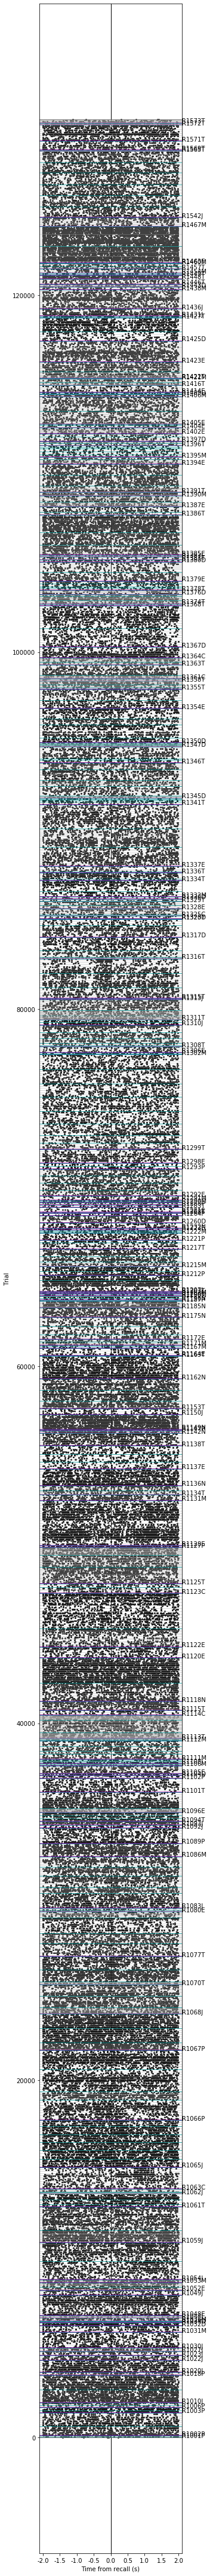

In [54]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

elec_dividers_on = 1 # toggles gray lines between electrodes
session_dividers_on = 1 # toggles cyan lines between sessions

width = 5
height = 60

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6) # purple
between_session_color = (0,0.6,0.6) # cyan

%autoreload
if selected_period == 'surrounding_recall':
    psth_start = -2000
    psth_end = 2000
elif selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300

# plot raster
subplots(1,1,figsize=(width,height))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.round(np.arange(psth_start,psth_end+1,500),2),np.round(np.arange(psth_start/1000,psth_end/1000+1,0.5),2))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()

ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

## PSTH with mixed effect CIs

In [55]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(129825, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
Are these three the same length?? They should be!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(129825, 36)

129825

129825

## plot the PSTH

done binning start_arrays


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/home1/john/SWR/figures/MATH/SWR_FR1_nonHPC_MTL__0_soz_in_hamming_whole.p
Test 1 p-value: 0.0021165549563407766
Test 2 p-value: 0.08725292945836038
129825 problems


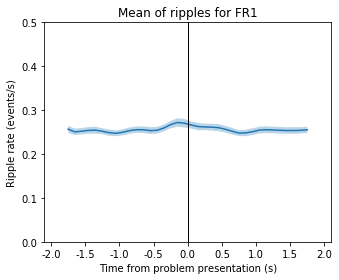

In [56]:
save_plot_data = 1

plot_sig_bars = 0

# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(5,4)) 
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem presentation (s)')
ylabel('Ripple rate (events/s)')
title('Mean of ripples for '+exp)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.5 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' problems')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

## get indices for slow and fast problems

In [57]:
# get slow and fast math problems

valid_idxs = rectime_array<30000
median_rectime = np.nanmedian(rectime_array[valid_idxs])
slow_idxs = ( (rectime_array>median_rectime) & valid_idxs )
fast_idxs = (rectime_array<median_rectime)

done making binned start_array with shape:
(64622, 36)
done making binned start_array with shape:
(64625, 36)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


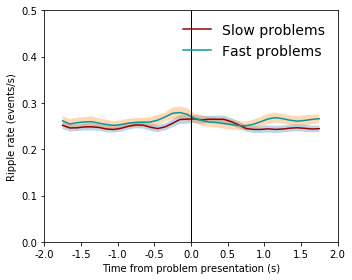

In [58]:
# Plot 1st-2nd for 2p and 1st-3rd pres for 3p 

%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

psth_start = -2000
psth_end = 2000
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2


for category in range(0,2): # slow then fast
        
    if category == 0:
        # for plot
        subplots(1,1,figsize=(5,4))        
        temp_idxs = slow_idxs
        label = 'Slow problems'  
        plot_color = (0.6,0,0) 
    elif category == 1:
        temp_idxs = fast_idxs
        label = 'Fast problems'  
        plot_color = (0,0.6,0.6)
        
    temp_start_array = start_array[temp_idxs]
    temp_subject_name_array = subject_name_array[temp_idxs]
    temp_session_name_array = session_name_array[temp_idxs] 
        
    # make a PSTH based on start times of SWRs                                                     

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,psth_start)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean

    if (plot_SEs == 1) & (category in [1,3,4,5]):
        SE_plot = getMixedEffectSEs(binned_start_array,temp_subject_name_array,temp_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    
    if plot_SEs == 1:
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
        
    xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
    
    xlabel('Time from problem presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(psth_start,psth_end)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
        
    if category == 1:
        leg = ax.legend(frameon=False,prop={'size': 14},loc='upper right')
        show()     
a=1;